In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt
import re
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# DBSCAN

Подготовка данных для UMAP...
Снижение размерности через UMAP...


C:\Users\MadBoss\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Кластеризация DBSCAN по эмбеддингам UMAP...


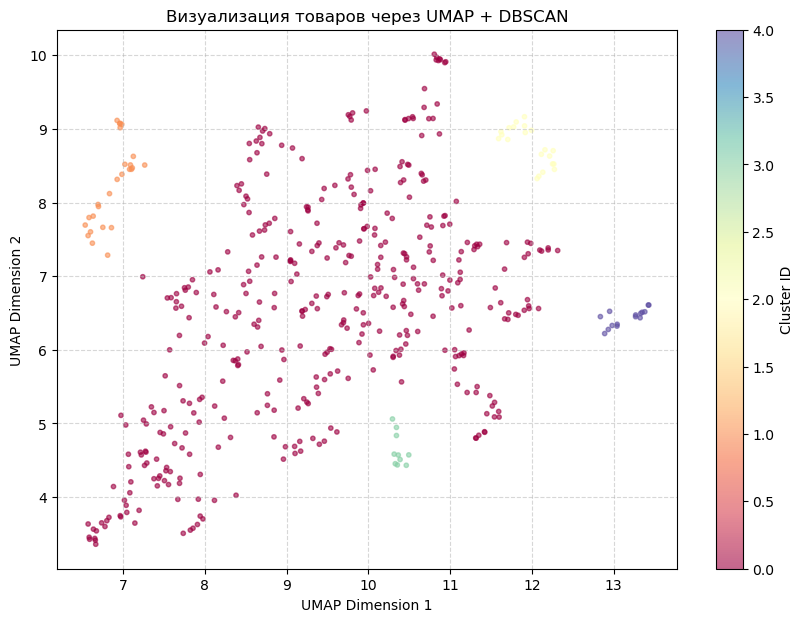

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import umap  # pip install umap-learn

# 0. МЕТРИКА
def calculate_iou(lower_true, upper_true, lower_pred, upper_pred, epsilon=1e-6):
    intersection = np.maximum(0, np.minimum(upper_true, upper_pred) - np.maximum(lower_true, lower_pred))
    union = (upper_true - lower_true + epsilon) + (upper_pred - lower_pred + epsilon) - intersection
    return np.mean(intersection / union)

def add_cyclical_features(df):
    if 'day_of_month' not in df.columns:
        df['day_of_month'] = df['dt'].dt.day
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)
    return df

# 1. ЗАГРУЗКА ДАННЫХ
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 2. UMAP + DBSCAN КЛАСТЕРИЗАЦИЯ
print("Подготовка данных для UMAP...")
pivot_train = train.pivot_table(index='product_id', columns='dt', values='price_p95').fillna(0)
scaler = StandardScaler()
pivot_scaled = scaler.fit_transform(pivot_train)

print("Снижение размерности через UMAP...")
# n_components=2 для визуализации и фичей
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(pivot_scaled)

print("Кластеризация DBSCAN по эмбеддингам UMAP...")
# После UMAP плотность выше, поэтому eps обычно небольшой
dbscan = DBSCAN(eps=0.5, min_samples=5)
cluster_labels = dbscan.fit_predict(umap_embeddings)

# Создаем DataFrame с новыми признаками
umap_features_df = pd.DataFrame(
    umap_embeddings, 
    index=pivot_train.index, 
    columns=['umap_coord_1', 'umap_coord_2']
)
umap_features_df['cluster_id'] = cluster_labels

# Добавляем в основные таблицы
train = train.merge(umap_features_df, on='product_id', how='left')
test = test.merge(umap_features_df, on='product_id', how='left')

# ГРАФИК
plt.figure(figsize=(10, 7))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], 
                      c=cluster_labels, cmap='Spectral', s=10, alpha=0.6)
plt.colorbar(scatter, label='Cluster ID')
plt.title('Визуализация товаров через UMAP + DBSCAN')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [20]:
# 3. ОПРЕДЕЛЕНИЕ ПРИЗНАКОВ
cat_features = [
    'management_group_id', 'first_category_id', 'second_category_id', 
    'third_category_id', 'product_id', 'activity_flag', 'cluster_id'
]

# Добавляем координаты UMAP в числовые фичи
features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year', 'day_sin', 'day_cos',
    'umap_coord_1', 'umap_coord_2'
] + cat_features

# Приводим категории к int
for col in cat_features:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

# 4. ВАЛИДАЦИЯ
max_train_date = train['dt'].max()
val_start_date = max_train_date - pd.Timedelta(days=4)

train_part = train[train['dt'] < val_start_date]
val_part = train[train['dt'] >= val_start_date]

cb_params = {
    'iterations': 2000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'MAE', 
    'random_seed': 42,
    'verbose': 0,
    'early_stopping_rounds': 100
}

print("Шаг 1: Поиск лучших итераций на валидации...")
tmp_low = CatBoostRegressor(**cb_params).fit(
    train_part[features], train_part['price_p05'], 
    eval_set=(val_part[features], val_part['price_p05']), 
    cat_features=cat_features, use_best_model=True
)
tmp_high = CatBoostRegressor(**cb_params).fit(
    train_part[features], train_part['price_p95'], 
    eval_set=(val_part[features], val_part['price_p95']), 
    cat_features=cat_features, use_best_model=True
)

best_iter_low = tmp_low.get_best_iteration()
best_iter_high = tmp_high.get_best_iteration()

# 5. ФИНАЛЬНОЕ ОБУЧЕНИЕ
print(f"Шаг 2: Переобучение (Low Iter: {best_iter_low}, High Iter: {best_iter_high})...")
final_model_low = CatBoostRegressor(**{**cb_params, 'iterations': best_iter_low + 1, 'early_stopping_rounds': None})
final_model_high = CatBoostRegressor(**{**cb_params, 'iterations': best_iter_high + 1, 'early_stopping_rounds': None})

final_model_low.fit(train[features], train['price_p05'], cat_features=cat_features, verbose=100)
final_model_high.fit(train[features], train['price_p95'], cat_features=cat_features, verbose=100)

# 6. ПРЕДСКАЗАНИЕ
test['price_p05'] = final_model_low.predict(test[features])
test['price_p95'] = final_model_high.predict(test[features])
test['price_p95'] = np.maximum(test['price_p95'], test['price_p05'] + 0.001)

submission = test[['row_id', 'price_p05', 'price_p95']].sort_values('row_id')
submission.to_csv('submission_final.csv', index=False)
print("Готово!")

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

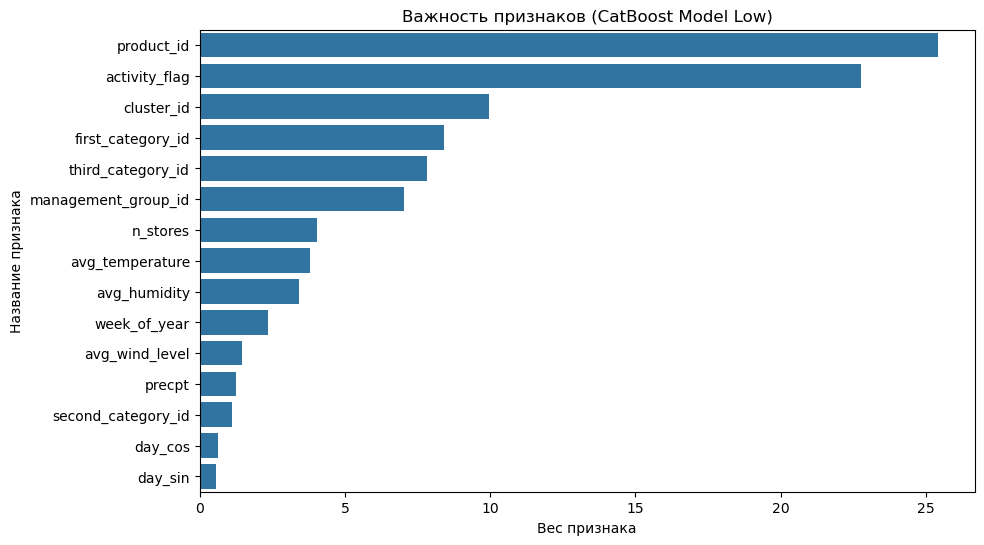

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_model_low.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()

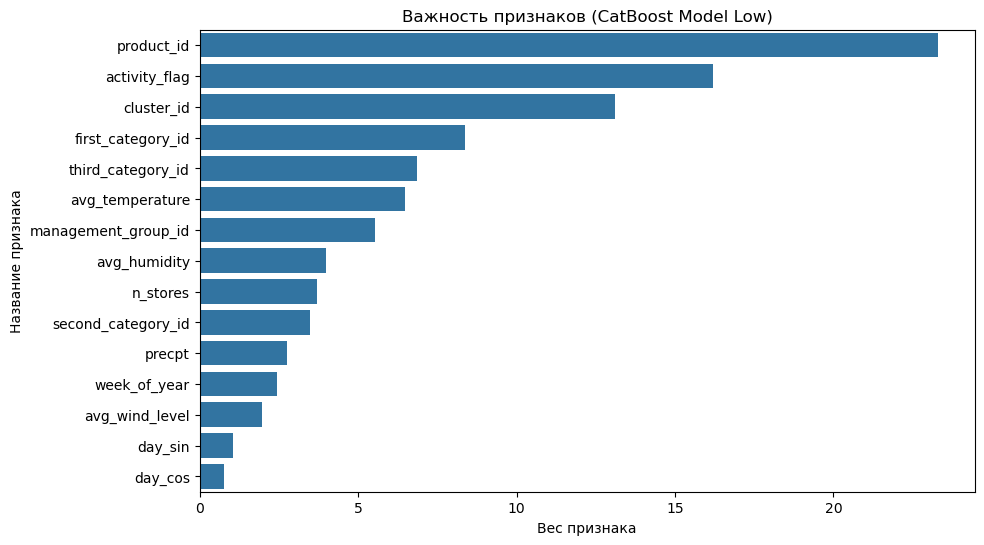

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_model_high.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()

In [16]:
train_part['cluster_id'].value_counts()

cluster_id
 1     16170
-1      8360
 0       220
 5       220
 4       220
 2       165
 3       165
 12      165
 6       165
 7       165
 8       165
 9       165
 10      165
 11      165
Name: count, dtype: int64

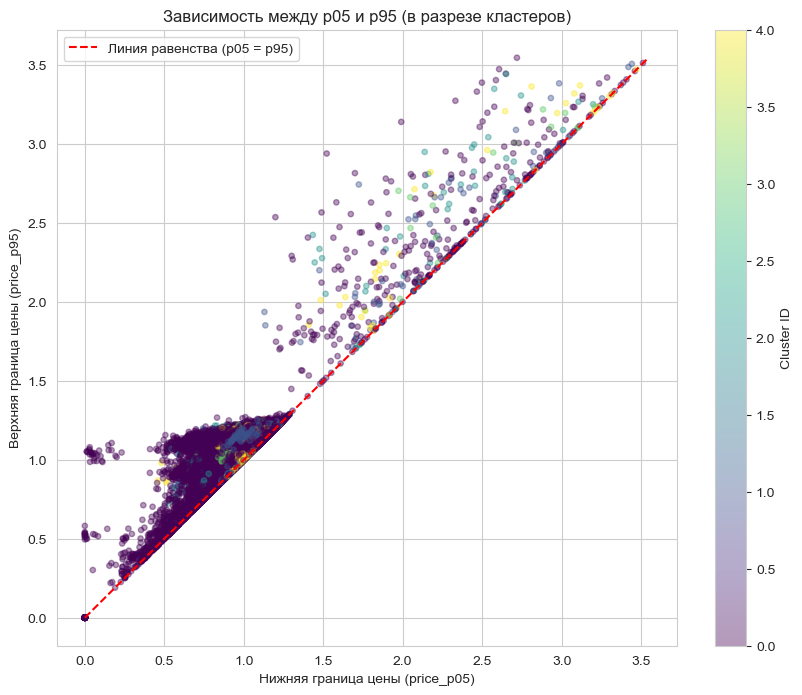

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настраиваем стиль
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Строим Scatter Plot
# Сделаем точки полупрозрачными (alpha), чтобы видеть плотность
scatter = plt.scatter(
    train['price_p05'], 
    train['price_p95'], 
    alpha=0.4, 
    c=train['cluster_id'], # Раскрасим по кластерам, которые мы создали ранее
    cmap='viridis',
    s=15
)

# Добавляем линию y = x, чтобы видеть, где границы смыкаются
max_val = max(train['price_p05'].max(), train['price_p95'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Линия равенства (p05 = p95)')

plt.xlabel('Нижняя граница цены (price_p05)')
plt.ylabel('Верхняя граница цены (price_p95)')
plt.title('Зависимость между p05 и p95 (в разрезе кластеров)')
plt.colorbar(scatter, label='Cluster ID')
plt.legend()

plt.show()

In [29]:
train[train['price_p05'] <= 0]

,dt,price_p05,price_p95,n_stores,precpt,avg_temperature,avg_humidity,avg_wind_level,holiday_flag,activity_flag,...,dow,day_of_month,week_of_year,month,product_id,day_sin,day_cos,umap_coord_1,umap_coord_2,cluster_id
2880,2024-03-28,0.0,0.000273,-0.267118,0.054012,0.370250,0.674286,0.473913,0,0,...,3,28,13,3,60,-5.712682e-01,0.820763,6.665548,3.359918,0
2881,2024-03-29,0.0,0.000281,-0.253269,-0.246186,0.388363,0.624159,-1.475837,0,0,...,4,29,13,3,60,-3.943559e-01,0.918958,6.665548,3.359918,0
2882,2024-03-30,0.0,0.000284,-0.224588,-0.126805,0.387697,0.599017,0.532008,1,0,...,5,30,13,3,60,-2.012985e-01,0.979530,6.665548,3.359918,0
2883,2024-03-31,0.0,0.000276,-0.287510,-0.190957,0.554463,0.552179,0.406418,1,0,...,6,31,13,3,60,-2.449294e-16,1.000000,6.665548,3.359918,0
2884,2024-04-01,0.0,0.000280,-0.235483,-0.053511,0.585383,0.511938,0.874380,0,0,...,0,1,14,4,60,2.012985e-01,0.979530,6.665548,3.359918,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20935,2024-05-22,0.0,0.000258,0.458513,-0.729096,0.282263,-0.446389,0.961353,0,0,...,2,22,21,5,452,-9.680771e-01,-0.250653,6.590236,3.427363,0
20936,2024-05-23,0.0,0.000286,0.472831,-0.474444,0.534475,-0.401303,0.918446,0,1,...,3,23,21,5,452,-9.987165e-01,-0.050649,6.590236,3.427363,0
20937,2024-05-24,0.0,0.000256,0.426378,-0.797356,0.345968,-0.243211,1.147511,0,0,...,4,24,21,5,452,-9.884683e-01,0.151428,6.590236,3.427363,0
20938,2024-05-25,0.0,0.000269,0.493545,-0.705827,0.569424,-0.405296,0.937326,1,0,...,5,25,21,5,452,-9.377521e-01,0.347305,6.590236,3.427363,0
